In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing, model_selection, metrics
from sklearn.naive_bayes import CategoricalNB, GaussianNB

In [188]:
df = pd.read_csv('adult.csv')
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


What are we missing in the data?

In [189]:
(df.where(df == "?")).count()

age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64

Let's remove all rows that have any missing data, since it makes up only a negligible amount of the total data

In [190]:
# remove messy rows
print('total rows:', len(df))
df_clean = df[df != '?'].dropna()
print('rows left:', len(df_clean))
print('rows removed:', len(df) - len(df_clean))
df_clean
(df_clean.where(df_clean == "?")).count()

total rows: 32561
rows left: 30162
rows removed: 2399


age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

Here, we will make our training and test splits:

In [191]:
var_names = list(df_clean.columns)
var_names.remove('income')
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(df_clean[var_names], df_clean['income'], test_size=0.33, random_state=42)
print(len(X_train))
print(len(X_test))
print(len(Y_train))
print(len(Y_test))

20208
9954
20208
9954


For our preprocessing, we will label encode all of our categorical attributes, and do a standard scaling for all of our continuous attributes.

In [192]:
# preprocess categorical data
cat_names = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']
df_cat_str = df_clean[cat_names]

cat_encoders = {}

X_train_cat = pd.DataFrame()
X_test_cat = pd.DataFrame()
for col in cat_names:
    # fit encoders
    encoder = preprocessing.LabelEncoder().fit(df_cat_str[col])
    cat_encoders[col] = encoder

    # transform data to labels
    X_train_cat[col] = encoder.transform(X_train[col])
    X_test_cat[col] = encoder.transform(X_test[col])

In [193]:
cont_names = ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']
df_cont = df_clean[cont_names]

scaler = preprocessing.StandardScaler().fit(df_cont)

X_train_cont = pd.DataFrame()
X_test_cont = pd.DataFrame()
X_train_cont[cont_names] = scaler.transform(X_train[cont_names])
X_test_cont[cont_names] = scaler.transform(X_test[cont_names])

And now, we train our models over the categorical and continuous data seperately:

In [194]:
cat_NB = CategoricalNB()
cat_NB.fit(X_train_cat, Y_train)

CategoricalNB()

In [195]:
cont_NB = GaussianNB()
cont_NB.fit(X_train_cont, Y_train)

GaussianNB()

In order to predict with both of our models, we can multiply the inferred probabilites from both of our models and choose the one with the greatest likelihood. It is actually implemented using the log probabilities, which are all negative, so instead we find the minimum of their multiplication.

In [196]:
def predict(df):
    df = df.copy()
    for col, encoder in cat_encoders.items():
        df[col] = encoder.transform(df[col])
    df[cont_names] = scaler.transform(df[cont_names])

    # log probabilities to avoid underflow
    cat_ps = cat_NB.predict_log_proba(df[cat_names])
    cont_ps = cont_NB.predict_log_proba(df[cont_names])

    combined_ps = cat_ps * cont_ps
    return cont_NB.classes_[combined_ps.argmin(axis=1)]

Here's some metrics over our dataset:

              precision    recall  f1-score   support

       <=50K       0.95      0.83      0.89      8508
        >50K       0.42      0.74      0.54      1446

    accuracy                           0.82      9954
   macro avg       0.69      0.78      0.71      9954
weighted avg       0.87      0.82      0.84      9954



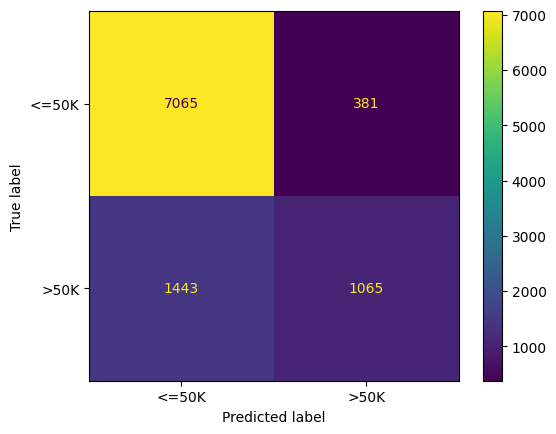

In [197]:
Y_hat = predict(X_test)
print(metrics.classification_report(Y_hat, Y_test))

conf_mat = metrics.confusion_matrix(Y_test, Y_hat)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=cont_NB.classes_)
disp.plot()
plt.show()